In [366]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import joblib
from sklearn.svm import SVC
import shap

In [367]:
df = pd.read_csv("dataFinal.csv", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   gender                            561 non-null    int64
 1   age                               561 non-null    int64
 2   education                         561 non-null    int64
 3   work_status                       561 non-null    int64
 4   injured_past_year                 561 non-null    int64
 5   head_injury                       561 non-null    int64
 6   chest_injury                      561 non-null    int64
 7   back_injury                       561 non-null    int64
 8   stomach_injury                    561 non-null    int64
 9   upper_body_injury                 561 non-null    int64
 10  lower_body_injury                 561 non-null    int64
 11  bruises                           561 non-null    int64
 12  sprains                           56

In [368]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    412
1    149
Name: count, dtype: int64

In [369]:
df_0 = df[df['emotional_mental_health_disorder'] == 0]
df_1 = df[df['emotional_mental_health_disorder'] == 1]

df_0_sample = df_0.sample(n=149)
df_1_sample = df_1.sample(n=149)

In [370]:
df_mental = pd.concat([df_0_sample, df_1_sample])

df_mental.sample(frac=1, random_state=42).reset_index(drop=True)

,gender,age,education,work_status,injured_past_year,head_injury,chest_injury,back_injury,stomach_injury,upper_body_injury,...,impaired,missing_body_parts,permanent_injury,place_of_injury,emotional_mental_health_disorder,has_injury,total_injuries,total_injury_severity,injured_body_parts_count,severe_injuries_count
0,2,52,2,6,1,2,2,2,2,2,...,2,2,2,5,1,1,16,29,16,13
1,2,61,2,6,1,2,2,2,2,2,...,2,2,2,2,1,1,16,30,16,14
2,2,50,3,6,1,2,2,2,2,2,...,2,2,2,2,1,1,16,30,16,14
3,2,53,2,6,1,2,2,2,2,2,...,2,2,2,1,0,1,16,30,16,14
4,2,58,2,6,1,2,2,2,2,2,...,2,2,2,5,0,1,16,29,16,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2,42,3,6,1,2,2,2,2,1,...,2,2,2,4,1,1,16,29,16,13
294,2,47,3,5,1,2,2,2,2,2,...,2,2,2,2,0,1,16,30,16,14
295,2,55,3,6,1,2,2,2,2,2,...,2,2,2,4,0,1,16,30,16,14
296,2,50,3,5,1,2,2,2,2,2,...,2,2,2,1,1,1,16,30,16,14


In [371]:
df['emotional_mental_health_disorder'].value_counts()

emotional_mental_health_disorder
0    412
1    149
Name: count, dtype: int64

In [372]:
X = df_mental.drop(['emotional_mental_health_disorder'], axis=1).values
y = df_mental['emotional_mental_health_disorder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

In [373]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
rf_model = grid_search.best_estimator_
rf_pred = rf_model.predict(X_test_pca)
rf_acc = accuracy_score(y_test, rf_pred) * 100
print(f"RF Accuracy: {rf_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, rf_pred))

RF Accuracy: 44.44% (Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50})
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        49
           1       0.38      0.37      0.38        41

    accuracy                           0.44        90
   macro avg       0.44      0.44      0.44        90
weighted avg       0.44      0.44      0.44        90



In [374]:
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9]}
grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
xgb_model = grid_search.best_estimator_
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred) * 100
print(f"XGBoost Accuracy: {xgb_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, xgb_pred))

c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 38.89% (Best Params: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200})
              precision    recall  f1-score   support

           0       0.44      0.43      0.43        49
           1       0.33      0.34      0.34        41

    accuracy                           0.39        90
   macro avg       0.39      0.39      0.39        90
weighted avg       0.39      0.39      0.39        90



In [375]:
param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
lr_model = grid_search.best_estimator_
lr_pred = lr_model.predict(X_test_pca)
lr_acc = accuracy_score(y_test, lr_pred) * 100
print(f"Logistic Regression Accuracy: {lr_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 48.89% (Best Params: {'C': 1, 'solver': 'lbfgs'})
              precision    recall  f1-score   support

           0       0.54      0.41      0.47        49
           1       0.45      0.59      0.51        41

    accuracy                           0.49        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.50      0.49      0.49        90



In [376]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}
grid_search = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
mlp_model = grid_search.best_estimator_
mlp_pred = mlp_model.predict(X_test_pca)
mlp_acc = accuracy_score(y_test, mlp_pred) * 100
print(f"MLP Accuracy: {mlp_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, mlp_pred))

MLP Accuracy: 47.78% (Best Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'})
              precision    recall  f1-score   support

           0       0.52      0.47      0.49        49
           1       0.43      0.49      0.46        41

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.48      0.48      0.48        90



In [377]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
svm_model = grid_search.best_estimator_
svm_pred = svm_model.predict(X_test_pca)
svm_acc = accuracy_score(y_test, svm_pred) * 100
print(f"SVM Accuracy: {svm_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 45.56% (Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'})
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        49
           1       0.43      0.59      0.49        41

    accuracy                           0.46        90
   macro avg       0.46      0.47      0.45        90
weighted avg       0.47      0.46      0.45        90



In [378]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)
knn_model = grid_search.best_estimator_
knn_pred = knn_model.predict(X_test_pca)
knn_acc = accuracy_score(y_test, knn_pred) * 100
print(f"KNN Accuracy: {knn_acc:.2f}% (Best Params: {grid_search.best_params_})")
print(classification_report(y_test, knn_pred))

KNN Accuracy: 38.89% (Best Params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'})
              precision    recall  f1-score   support

           0       0.41      0.29      0.34        49
           1       0.38      0.51      0.43        41

    accuracy                           0.39        90
   macro avg       0.39      0.40      0.39        90
weighted avg       0.40      0.39      0.38        90



In [379]:
print(f"Accuracy Scores:\nLogistic Regression: {lr_acc:.2f}\nXGBoost: {xgb_acc:.2f}\nRandom Forest: {rf_acc:.2f}\nNeural Network: {mlp_acc:.2f}\nSVM: {svm_acc:.2f}\nk-NN: {knn_acc:.2f}")

Accuracy Scores:
Logistic Regression: 48.89
XGBoost: 38.89
Random Forest: 44.44
Neural Network: 47.78
SVM: 45.56
k-NN: 38.89


In [380]:
print(f"{rf_acc:.2f} {xgb_acc:.2f} {lr_acc:.2f} {mlp_acc:.2f} {svm_acc:.2f} {knn_acc:.2f}")

44.44 38.89 48.89 47.78 45.56 38.89


In [381]:
def pickleModel(model, filename):
    pickle.dump(model, open(filename, 'wb'))

pickleModel(rf_model, 'models/RF.pkl')
pickleModel(xgb_model, 'models/XGB.pkl')
pickleModel(lr_model, 'models/LR.pkl')
pickleModel(mlp_model, 'models/NN.pkl')
pickleModel(svm_model, 'models/SVM.pkl')
pickleModel(knn_model, 'models/KNN.pkl')

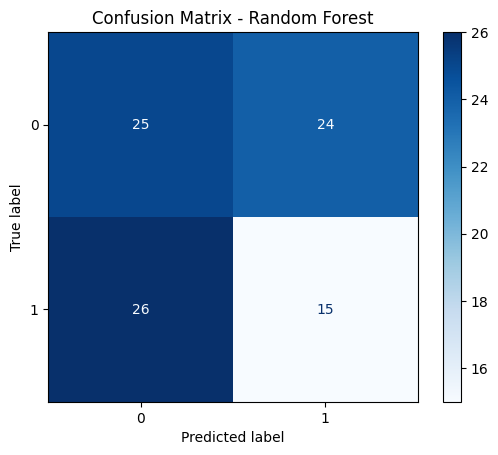

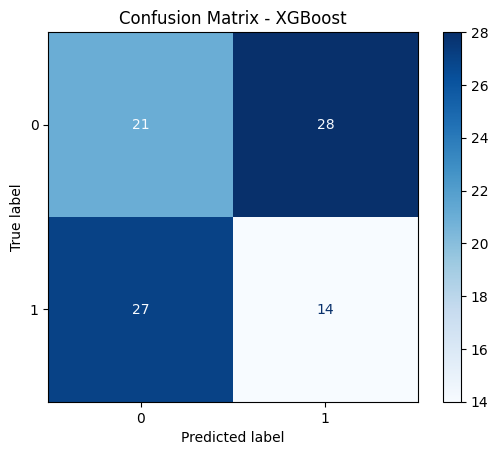

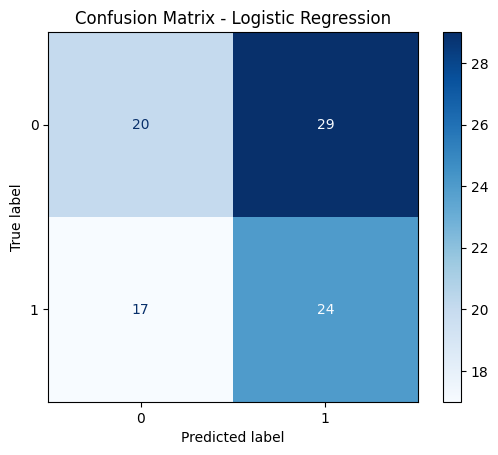

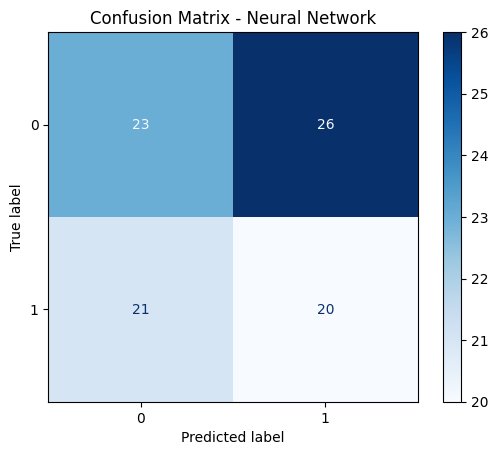

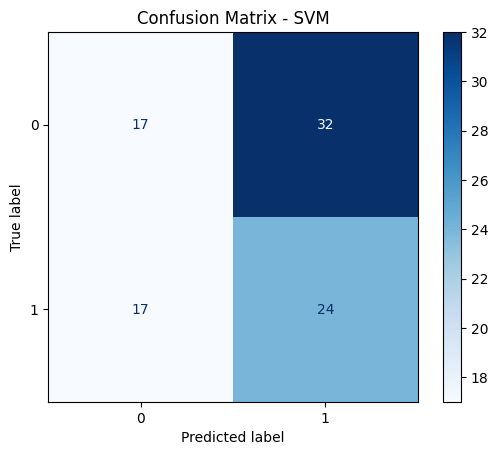

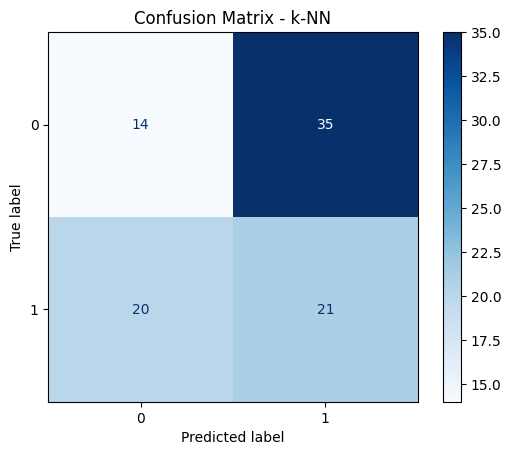

In [382]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(y_test, rf_pred, "Random Forest")
plot_confusion_matrix(y_test, xgb_pred, "XGBoost")
plot_confusion_matrix(y_test, lr_pred, "Logistic Regression")
plot_confusion_matrix(y_test, mlp_pred, "Neural Network")
plot_confusion_matrix(y_test, svm_pred, "SVM")
plot_confusion_matrix(y_test, knn_pred, "k-NN")

In [383]:
feature_names = df_mental.columns.tolist() 
feature_names.remove("emotional_mental_health_disorder")

In [384]:
print(feature_names)

['gender', 'age', 'education', 'work_status', 'injured_past_year', 'head_injury', 'chest_injury', 'back_injury', 'stomach_injury', 'upper_body_injury', 'lower_body_injury', 'bruises', 'sprains', 'severed_limbs', 'eye_injury', 'brain_damage', 'internal_damage', 'burns', 'other', 'impaired', 'missing_body_parts', 'permanent_injury', 'place_of_injury', 'has_injury', 'total_injuries', 'total_injury_severity', 'injured_body_parts_count', 'severe_injuries_count']


In [385]:
if isinstance(X_train, np.ndarray): 
    X_train = pd.DataFrame(X_train, columns=feature_names)

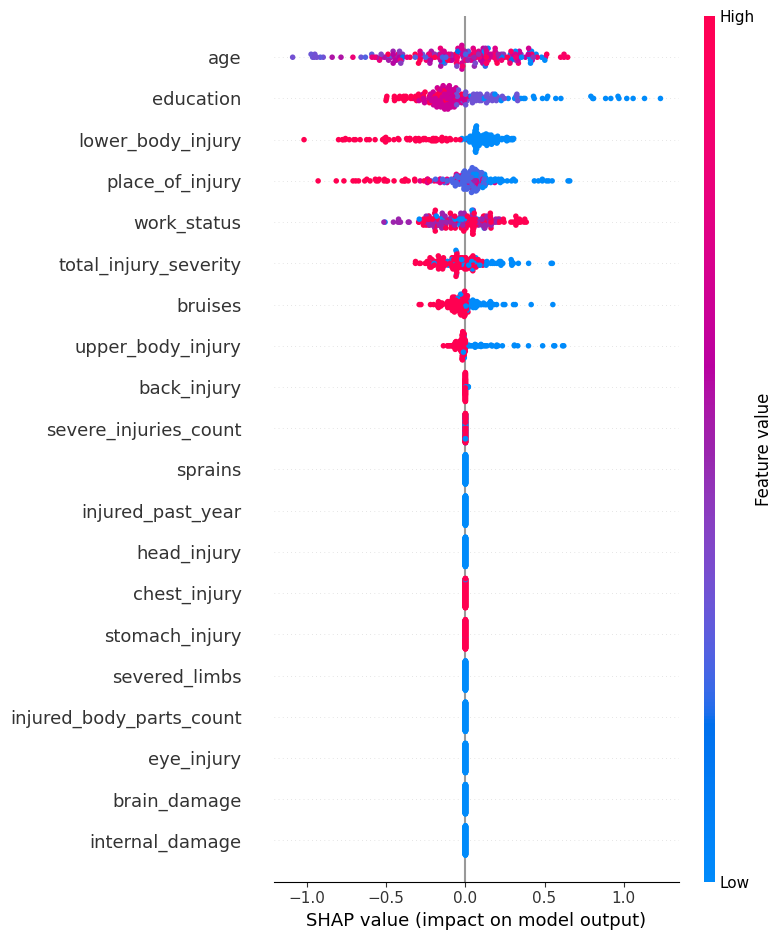

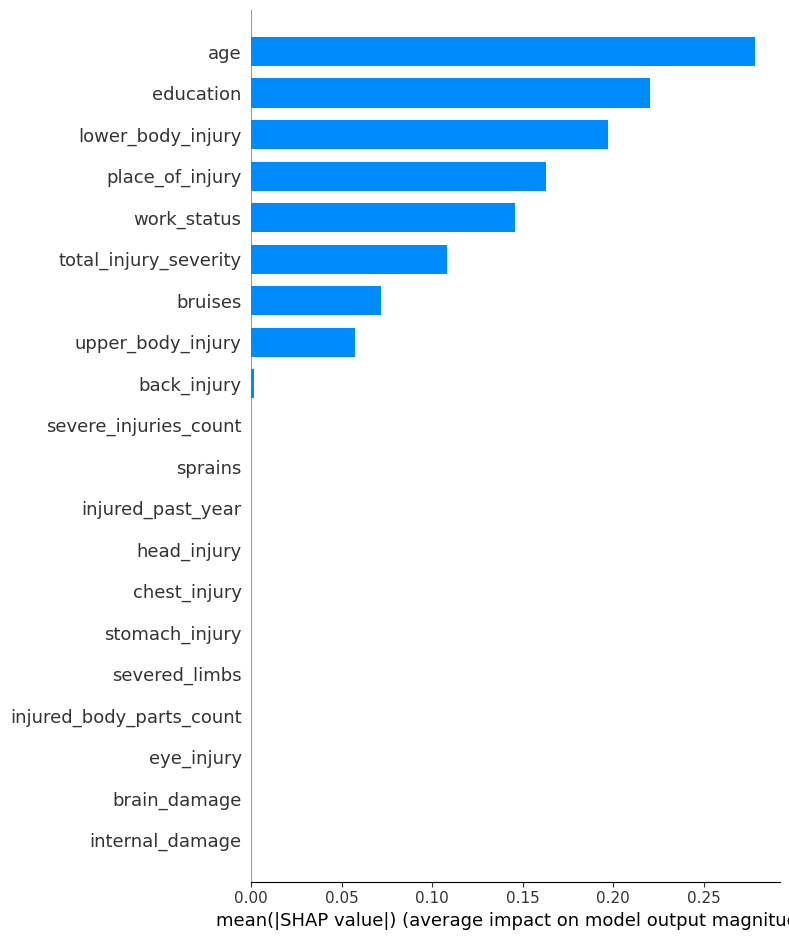

AttributeError: 'NoneType' object has no attribute 'shape'

In [386]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

shap.dependence_plot(shap_values.values, X_train)

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

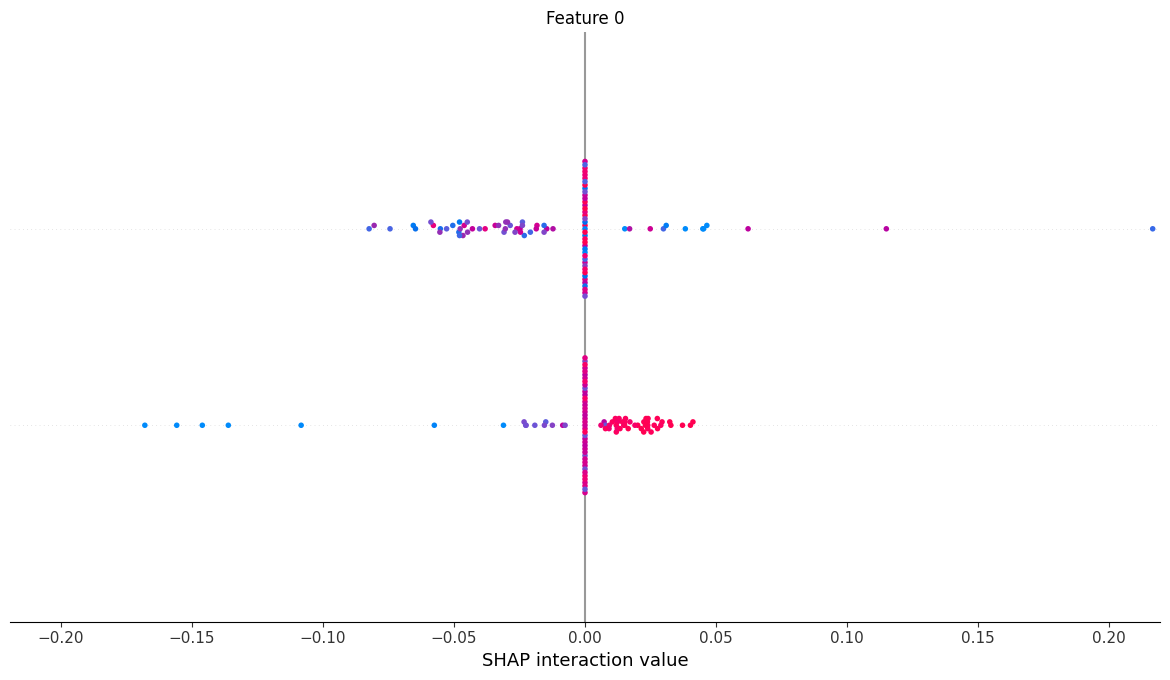

<Figure size 640x480 with 0 Axes>

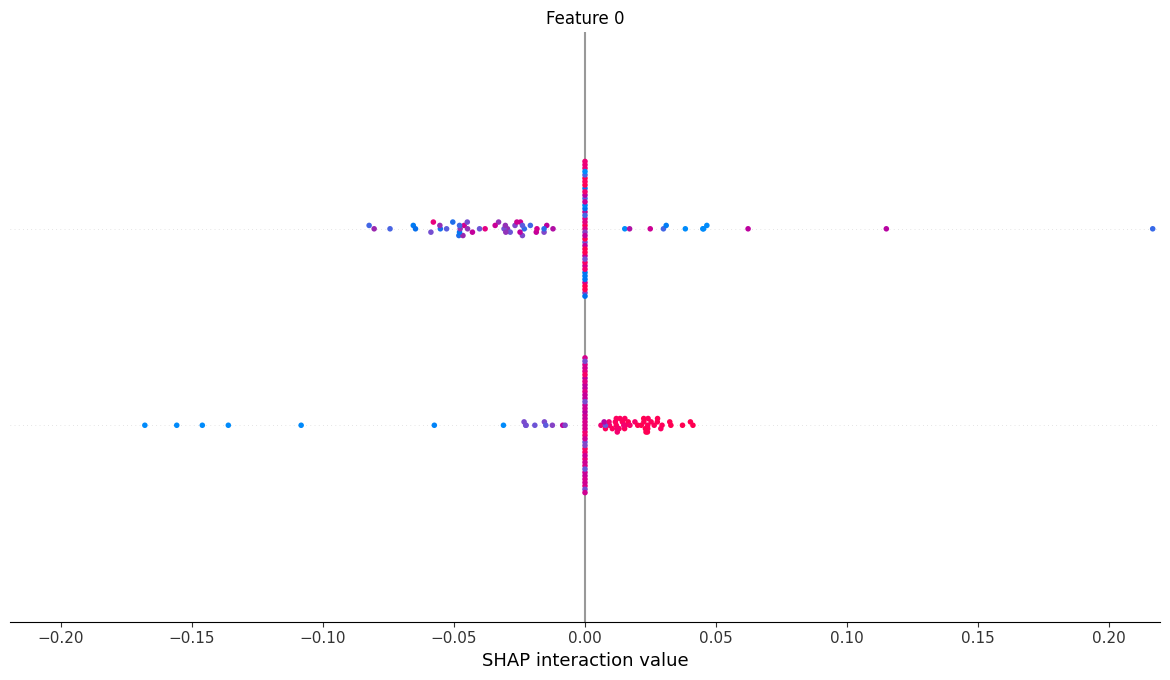

In [ ]:

# Define a wrapper function for prediction
def model_predict(X):
    return mlp_model.predict_proba(X)  # Use predict_proba for classification

# Number of samples to use for SHAP (adjust as needed)
num_samples = 100  # Choose a reasonable sample size

# Randomly select indices
random_indices = np.random.choice(X_train_pca.shape[0], num_samples, replace=False)

# Create a smaller sample from X_train_pca
X_sample = X_train_pca[random_indices]

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_sample)

# Compute SHAP values only for the sample
shap_values = explainer.shap_values(X_sample)

# Visualize results
shap.summary_plot(shap_values, X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")


In [ ]:

# top_5_features = feature_importances.nlargest(5, "Importance")["Feature"]

# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

# for i, feature in enumerate(top_5_features):
#     grouped_df = df.groupby(feature)[target_variable].value_counts(normalize=True).unstack()
    
#     grouped_df.plot(kind='bar', stacked=True, ax=axes[i], colormap="coolwarm", alpha=0.85)
    
#     axes[i].set_title(feature)
#     axes[i].set_xlabel("")
#     axes[i].set_ylabel("Proportion")
#     axes[i].legend(title="Emotional Mental Health Disorder", labels=["0 (No)", "1 (Yes)"])

# plt.tight_layout()
# plt.show()

